In [1]:
import os
import sys
from nrel_uitls import CLIMATEZONES, RESTYPES
import json
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import matplotlib.pyplot as plt
import numpy as np
# import h5py
# from storage import upload_to_bucket

from schema import Schema, TimeSeriesOutput, ShoeboxGeometryParameter, BuildingTemplateParameter, WhiteboxSimulation, WindowParameter, SchedulesParameters


c:\Users\zoele\anaconda3\envs\ml-for-bem\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
timeseries = [
    TimeSeriesOutput(
        name="DistrictCooling",
        # var_name="Cooling:DistrictCooling",
        key_name="Cooling:DistrictCooling",
        key="OUTPUT:METER",
        freq="Monthly",
        store_output=True,
    ),
    TimeSeriesOutput(
        name="DistrictHeating",
        key_name="Heating:DistrictHeating",
        key="OUTPUT:METER",
        freq="Monthly",
        store_output=True,
    ),
    TimeSeriesOutput(
        name="Supply Air Heating",
        var_name="Zone Ideal Loads Supply Air Total Heating Energy",
        key="OUTPUT:VARIABLE",
        freq="Hourly",
        store_output=True,
    ),
    TimeSeriesOutput(
        name="Supply Air Cooling",
        var_name="Zone Ideal Loads Supply Air Total Cooling Energy",
        key="OUTPUT:VARIABLE",
        freq="Hourly",
        store_output=True,
    ),
    TimeSeriesOutput(
        name="OA Heating",
        var_name="Zone Ideal Loads Outdoor Air Total Heating Energy",
        key="OUTPUT:VARIABLE",
        freq="Hourly",
        store_output=True,
    ),
    TimeSeriesOutput(
        name="OA Cooling",
        var_name="Zone Ideal Loads Outdoor Air Total Cooling Energy",
        key="OUTPUT:VARIABLE",
        freq="Hourly",
        store_output=True,
    ),
    #Zone Ideal Loads Supply Air Total Heating Energy 
    #Zone Ideal Loads Zone Total Heating Energy
]
schema = Schema(timeseries_outputs=timeseries)
# schema = Schema()

In [3]:
with open("./data/city_map.json","r") as f:
	city_map = json.load(f)

In [4]:
storage_vector = schema.generate_empty_storage_vector()
# just using 
# TODO: orientation
# TODO: setpoint value overlaps
# TODO: Fix template Selector
# TODO: window u value coming out different
schema.update_storage_vector(storage_vector, parameter="climate_zone", value=CLIMATEZONES["2A"])
schema.update_storage_vector(storage_vector, parameter="vintage", value=1920)
schema.update_storage_vector(storage_vector, parameter="program_type", value=RESTYPES["Multi-Family with 5+ Units"])
schema.update_storage_vector(storage_vector, parameter="base_epw", value=city_map["CA, Los Angeles"]["idx"])
schema.update_storage_vector(storage_vector, "height", 3)
schema.update_storage_vector(storage_vector, "width", 3)
schema.update_storage_vector(storage_vector, "facade_2_footprint", 0.3)
schema.update_storage_vector(storage_vector, "perim_2_footprint", 0.5)
schema.update_storage_vector(storage_vector, "roof_2_footprint", 0.05)
schema.update_storage_vector(storage_vector, "footprint_2_ground", 0.5)
schema.update_storage_vector(storage_vector, "wwr", 0.3)
schema.update_storage_vector(storage_vector, "orientation", 0)
schema.update_storage_vector(storage_vector, "Infiltration", 1.0)
schema.update_storage_vector(storage_vector, "HeatingSetpoint", 18)
schema.update_storage_vector(storage_vector, "CoolingSetpoint", 24)
schema.update_storage_vector(storage_vector, "PeopleDensity", 0.05)
schema.update_storage_vector(storage_vector, "LightingPowerDensity", 3)
schema.update_storage_vector(storage_vector, "EquipmentPowerDensity", 7)
schema.update_storage_vector(storage_vector, "RoofRValue", 2)
schema.update_storage_vector(storage_vector, "SlabRValue", 2)
schema.update_storage_vector(storage_vector, "FacadeRValue", 2)
schema.update_storage_vector(storage_vector, "FacadeMass", 10000) 
schema.update_storage_vector(storage_vector, "RoofMass", 10000)
schema.update_storage_vector(storage_vector, "WindowSettings", np.array([1.0,0.5,0.5])) 

schedules = schema["schedules"].extract_storage_values(storage_vector)
sched_demo = "NONE"
if sched_demo == "BASELINE":
    # Equipment
    # pass
    # Occupancy
    schedules[1, SchedulesParameters.op_indices["noise"]] = 0.2
    # Lights
    schedules[2, SchedulesParameters.op_indices["invert"]] = 1
elif sched_demo == "SINE":
    # Equipment
    schedules[0, SchedulesParameters.op_indices["sin_overwrite"]] = 1
    schedules[0, SchedulesParameters.op_indices["sin_0_amp"]] = 0.5
    schedules[0, SchedulesParameters.op_indices["sin_0_freq"]] = 365
    # Occupancy
    schedules[1, SchedulesParameters.op_indices["sin_overwrite"]] = 1
    schedules[1, SchedulesParameters.op_indices["sin_0_amp"]] = 0.5
    schedules[1, SchedulesParameters.op_indices["sin_0_freq"]] = 365
    schedules[1, SchedulesParameters.op_indices["sin_1_amp"]] = 0.5
    schedules[1, SchedulesParameters.op_indices["sin_1_freq"]] = 4
    # Lights
    schedules[2, SchedulesParameters.op_indices["sin_overwrite"]] = 1
    schedules[2, SchedulesParameters.op_indices["sin_0_amp"]] = 1.0
    schedules[2, SchedulesParameters.op_indices["sin_0_freq"]] = 24 # 2 per mo
elif sched_demo == "BERNOULLI":
    # Equipment
    schedules[0, SchedulesParameters.op_indices["uniform_random_dilation"]] = 1 # hours per sample
    schedules[0, SchedulesParameters.op_indices["uniform_random_samples"]] = 10 # samples per pattern
    schedules[0, SchedulesParameters.op_indices["uniform_random_mode"]] = 1 # bernoulli
    # Occupancy
    schedules[1, SchedulesParameters.op_indices["uniform_random_dilation"]] = 1 # hours per sample
    schedules[1, SchedulesParameters.op_indices["uniform_random_samples"]] = 24*7 # samples per pattern
    schedules[1, SchedulesParameters.op_indices["uniform_random_mode"]] = 1 # bernoulli
    # Lights
    schedules[2, SchedulesParameters.op_indices["uniform_random_dilation"]] = 24 # hours per sample
    schedules[2, SchedulesParameters.op_indices["uniform_random_samples"]] = 24*7 # samples per pattern
    schedules[2, SchedulesParameters.op_indices["uniform_random_mode"]] = 1 # bernoulli
elif sched_demo == "UNI_RAND":
    # Equipment
    schedules[0, SchedulesParameters.op_indices["uniform_random_dilation"]] = 1 # hours per sample
    schedules[0, SchedulesParameters.op_indices["uniform_random_samples"]] = 24*7 # samples per pattern
    schedules[0, SchedulesParameters.op_indices["uniform_random_mode"]] = 0 # continuous

    # Occupancy
    schedules[1, SchedulesParameters.op_indices["uniform_random_dilation"]] = 1 # hours per sample
    schedules[1, SchedulesParameters.op_indices["uniform_random_samples"]] = 24 # samples per pattern
    schedules[1, SchedulesParameters.op_indices["uniform_random_mode"]] = 0 # continuous

    # Lights
    schedules[2, SchedulesParameters.op_indices["uniform_random_dilation"]] = 1 # hours per sample
    schedules[2, SchedulesParameters.op_indices["uniform_random_samples"]] = 22 # samples per pattern
    schedules[2, SchedulesParameters.op_indices["uniform_random_mode"]] = 0 # continuous
elif sched_demo == "PULSE":
    # Equipment
    schedules[0, SchedulesParameters.op_indices["pulse_period"]] = 24*7 # 7 day cycle
    schedules[0, SchedulesParameters.op_indices["pulse_width"]] = 24*5 # on for 5 days

    # Occupancy
    schedules[1, SchedulesParameters.op_indices["pulse_period"]] = 24 # 1 day cycle
    schedules[1, SchedulesParameters.op_indices["pulse_width"]] = 15 # on for 5 days

    # Lights
    schedules[2, SchedulesParameters.op_indices["pulse_period"]] = 23 # 23 hr cycle
    schedules[2, SchedulesParameters.op_indices["pulse_width"]] = 18 # on for 11 hrs

# schedules[2, SchedulesParameters.op_indices["noise"]] = 0.5 # Occupancy
schedules[1, SchedulesParameters.op_indices["noise"]] = 0.3 # Lights
# schedules[0, SchedulesParameters.op_indices["noise"]] = 0.5 # equip

In [5]:
whitebox_sim = WhiteboxSimulation(schema, storage_vector)
# whitebox_sim.summarize()

In [7]:
heights = np.random.rand(30)*20
whitebox_sim.build_shading(heights, radius=40)

In [7]:
whitebox_sim.shoebox.getshadingsurfaces()

[
 SHADING:BUILDING:DETAILED,
     SHADER_0,                 !- Name
     ,                         !- Transmittance Schedule Name
     4,                        !- Number of Vertices
     -38.5,                    !- Vertex 1 Xcoordinate
     0.0,                      !- Vertex 1 Ycoordinate
     10.480812746833317,       !- Vertex 1 Zcoordinate
     -38.5,                    !- Vertex 2 Xcoordinate
     0.0,                      !- Vertex 2 Ycoordinate
     0.0,                      !- Vertex 2 Zcoordinate
     -38.28087581473093,       !- Vertex 3 Xcoordinate
     -4.181138530706138,       !- Vertex 3 Ycoordinate
     0.0,                      !- Vertex 3 Zcoordinate
     -38.28087581473093,       !- Vertex 4 Xcoordinate
     -4.181138530706138,       !- Vertex 4 Ycoordinate
     10.480812746833317;       !- Vertex 4 Zcoordinate,
 
 SHADING:BUILDING:DETAILED,
     SHADER_1,                 !- Name
     ,                         !- Transmittance Schedule Name
     4,                 

In [9]:
res_hourly, res_monthly = whitebox_sim.simulate()

C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-a5f03998-378e-11ee-be50-93867c2ad5d0.idf: 4.00it [00:00, 8.01it/s]
C:\EnergyPlusV9-2-0\energyplus.exe a5f03998-378e-11ee-be50-93867c2ad5d0.idf: 55it [00:07,  7.02it/s]


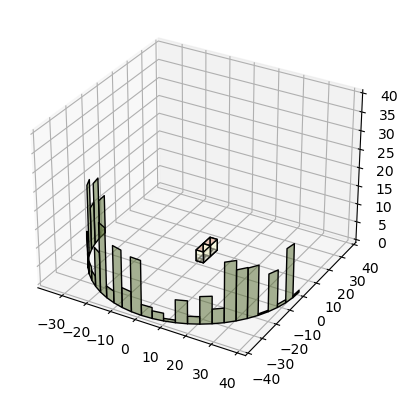

<Figure size 640x480 with 0 Axes>

(<Figure size 640x480 with 0 Axes>, [])

In [10]:
# simulate first to see shading!
whitebox_sim.shoebox.view_model()

In [17]:
for out in whitebox_sim.schema.timeseries_outputs:
    print(out.var_name if out.key_name is None else out.key_name)

Zone Ideal Loads Zone Total Heating Energy
Zone Ideal Loads Zone Total Cooling Energy
Lights Total Heating Energy
Zone Windows Total Transmitted Solar Radiation Energy
Cooling:DistrictCooling
Heating:DistrictHeating
Zone Ideal Loads Supply Air Total Heating Energy
Zone Ideal Loads Supply Air Total Cooling Energy


In [8]:
res_monthly


IndexGroup,Facility:DistrictHeating:Heating,Facility:DistrictCooling:Cooling
KeyValue,,
Name,Heating:DistrictHeating,Cooling:DistrictCooling
2018-01-01,5.410574e+08,3.396989e+08
2018-02-01,3.585966e+08,3.932576e+08
2018-03-01,2.946965e+08,3.082693e+08
2018-04-01,1.719650e+08,3.420394e+08
2018-05-01,5.435093e+07,3.659229e+08
2018-06-01,9.166530e+06,6.201904e+08
2018-07-01,0.000000e+00,1.062237e+09
2018-08-01,0.000000e+00,1.068249e+09


In [18]:
res_hourly.head()

IndexGroup                                                    System  \
KeyValue                 BLOCK PERIM STOREY 0 IDEAL LOADS AIR SYSTEM   
Name                Zone Ideal Loads Supply Air Total Heating Energy   
2018-01-01 00:00:00                                         0.000000   
2018-01-01 01:00:00                                    129595.998602   
2018-01-01 02:00:00                                    378041.246208   
2018-01-01 03:00:00                                    619311.680120   
2018-01-01 04:00:00                                    744061.943396   

IndexGroup                                                            \
KeyValue                                                               
Name                Zone Ideal Loads Supply Air Total Cooling Energy   
2018-01-01 00:00:00                                              0.0   
2018-01-01 01:00:00                                              0.0   
2018-01-01 02:00:00                                              0.0   
2018-01-01 03:00:00                                              0.0   
2018-01-01 04:00:00                                              0.0   

IndexGroup                                                      \
KeyValue                                                         
Name                Zone Ideal Loads Zone Total Heating Energy   
2018-01-01 00:00:00                                   0.000000   
2018-01-01 01:00:00                              129595.998602   
2018-01-01 02:00:00                              378041.246208   
2018-01-01 03:00:00                              619311.680120   
2018-01-01 04:00:00                              744061.943396   

IndexGroup                                                      \
KeyValue                                                         
Name                Zone Ideal Loads Zone Total Cooling Energy   
2018-01-01 00:00:00                               0.000000e+00   
2018-01-01 01:00:00                               1.940847e-09   
2018-01-01 02:00:00                               6.266987e-09   
2018-01-01 03:00:00                               1.880096e-08   
2018-01-01 04:00:00                               2.207514e-08   

IndexGroup                                                            \
KeyValue                  BLOCK CORE STOREY 0 IDEAL LOADS AIR SYSTEM   
Name                Zone Ideal Loads Supply Air Total Heating Energy   
2018-01-01 00:00:00                                     5.743836e+05   
2018-01-01 01:00:00                                     7.379556e+05   
2018-01-01 02:00:00                                     8.710539e+05   
2018-01-01 03:00:00                                     1.028869e+06   
2018-01-01 04:00:00                                     1.076233e+06   

IndexGroup                                                            \
KeyValue                                                               
Name                Zone Ideal Loads Supply Air Total Cooling Energy   
2018-01-01 00:00:00                                              0.0   
2018-01-01 01:00:00                                              0.0   
2018-01-01 02:00:00                                              0.0   
2018-01-01 03:00:00                                              0.0   
2018-01-01 04:00:00                                              0.0   

IndexGroup                                                      \
KeyValue                                                         
Name                Zone Ideal Loads Zone Total Heating Energy   
2018-01-01 00:00:00                               5.743836e+05   
2018-01-01 01:00:00                               7.379556e+05   
2018-01-01 02:00:00                               8.710539e+05   
2018-01-01 03:00:00                               1.028869e+06   
2018-01-01 04:00:00                               1.076233e+06   

IndexGroup                                                      
KeyValue                                

In [20]:
res_monthly.sum()


IndexGroup                        KeyValue  Name                   
Facility:DistrictHeating:Heating            Heating:DistrictHeating    2.366676e+09
Facility:DistrictCooling:Cooling            Cooling:DistrictCooling    6.560333e+09
dtype: float64

In [29]:
res_hourly.sum()

IndexGroup  KeyValue                                     Name                                            
System      BLOCK PERIM STOREY 0 IDEAL LOADS AIR SYSTEM  Zone Ideal Loads Supply Air Total Heating Energy    8.779674e+08
                                                         Zone Ideal Loads Supply Air Total Cooling Energy    5.268667e+09
                                                         Zone Ideal Loads Zone Total Heating Energy          8.779720e+08
                                                         Zone Ideal Loads Zone Total Cooling Energy          5.268671e+09
            BLOCK CORE STOREY 0 IDEAL LOADS AIR SYSTEM   Zone Ideal Loads Supply Air Total Heating Energy    1.488709e+09
                                                         Zone Ideal Loads Supply Air Total Cooling Energy    1.291667e+09
                                                         Zone Ideal Loads Zone Total Heating Energy          1.488710e+09
                                        

In [31]:
0.8779674+1.488709

2.3666764000000002

In [13]:
0.8779720+1.488710

2.366682